In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from functools import partial

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import PreTrainedTokenizer, AutoTokenizer
from transformer_lens import HookedTransformer
import torch.nn.functional as F

In [3]:
from eap.graph import Graph
from eap.evaluate import evaluate_graph, evaluate_baseline, evaluate_cross_graph
from eap.attribute import attribute 

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

def load_model(adapter_path, hf_model_name, translens_model_name, scratch_cache_dir = None):
    base_model = AutoModelForCausalLM.from_pretrained(hf_model_name, cache_dir=scratch_cache_dir)
    model_with_lora = PeftModel.from_pretrained(base_model, adapter_path)
    model_with_lora = model_with_lora.merge_and_unload()
    model = HookedTransformer.from_pretrained(model_name=translens_model_name, hf_model=model_with_lora, cache_dir=scratch_cache_dir)  

    model.cfg.use_split_qkv_input = True
    model.cfg.use_attn_result = True
    model.cfg.use_hook_mlp_in = True
    model.cfg.ungroup_grouped_query_attention = True
    return model

In [5]:
def collate_EAP(xs):
    clean, corrupted, labels = zip(*xs)
    clean = list(clean)
    corrupted = list(corrupted)
    return clean, corrupted, labels

class EAPDataset(Dataset):
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)

    def __len__(self):
        return len(self.df)
    
    def shuffle(self):
        self.df = self.df.sample(frac=1)

    def head(self, n: int):
        self.df = self.df.head(n)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        return row['clean'], row['corrupted'], row['answer']
    
    def to_dataloader(self, batch_size: int):
        return DataLoader(self, batch_size=batch_size, collate_fn=collate_EAP)
    
def get_logit_positions(logits: torch.Tensor, input_length: torch.Tensor):
    batch_size = logits.size(0)
    idx = torch.arange(batch_size, device=logits.device)

    logits = logits[idx, input_length - 1]
    return logits

def kl_divergence(logits: torch.Tensor, clean_logits: torch.Tensor, input_length: torch.Tensor, labels: torch.Tensor, mean=True, loss=True):
    logits = get_logit_positions(logits, input_length)
    clean_logits = get_logit_positions(clean_logits, input_length)

    probs = torch.softmax(logits, dim=-1)
    clean_probs = torch.softmax(clean_logits, dim=-1)
    results = F.kl_div(probs.log(), clean_probs.log(), log_target=True, reduction='none').mean(-1)
    return results.mean() if mean else results

In [6]:
scratch_cache_dir = "/mnt/faster0/rje41/.cache/huggingface"    
hf_model_name = "EleutherAI/pythia-1.4B-deduped"
translens_model_name="pythia-1.4B-deduped"
adapter_path = "../../old-fine-tunng/add_sub_nlp/checkpoints/prompt_template_prompt_template_0/checkpoint-500"
model = load_model(
        adapter_path=adapter_path,
        hf_model_name=hf_model_name,
        translens_model_name=translens_model_name,
        scratch_cache_dir=scratch_cache_dir,
    )


Loaded pretrained model pythia-1.4B-deduped into HookedTransformer


In [10]:
ds = EAPDataset('../../old-fine-tunng/add_sub_nlp/datasets_csv/prompts_id_1/test.csv')
dataloader = ds.to_dataloader(6)

In [11]:
g = Graph.from_model(model)
attribute(model, g, dataloader, partial(kl_divergence, loss=True, mean=True), method='EAP-IG-inputs', ig_steps=5)

total_edges = len(g.edges)

five_percent_edges = int(total_edges * 0.05)
g.apply_topn(five_percent_edges , absolute=True, prune=True)

100%|██████████| 84/84 [05:09<00:00,  3.68s/it]


In [12]:
g.to_json('graph_1.json')

In [7]:
def calculate_faithfulness(model, g, dataloader, metric_fn):
    baseline_performance = evaluate_baseline(model, dataloader, metric_fn).mean().item()
    circuit_performance = evaluate_graph(model, g, dataloader, metric_fn,skip_clean=False).mean().item()
    faithfulness = abs(baseline_performance - circuit_performance)
    percentage_performance = (1 - faithfulness / baseline_performance) * 100

    print(f"Baseline performance: {baseline_performance}")
    print(f"Circuit performance: {circuit_performance}")
    print(f"Faithfulness: {faithfulness}")
    print(f"Percentage of model performance achieved by the circuit: {percentage_performance:.2f}%")

    return baseline_performance, circuit_performance, faithfulness, percentage_performance

In [8]:
def exact_match_accuracy(model, logits, corrupted_logits, input_lengths, labels):
    batch_size = logits.size(0)
    device = logits.device
    positions = input_lengths - 1

    last_logits = logits[torch.arange(batch_size), positions, :]
    predicted_tokens = last_logits.argmax(dim=-1)
    predicted_strings = [model.to_string(token.item()).strip() for token in predicted_tokens]

    labels_strings = []
    for i in range(batch_size):
        lab = labels[i]
        if isinstance(lab, torch.Tensor):
            lab = lab.item()
        labels_strings.append(str(lab).strip())

    correct = []
    for pred_str, label_str in zip(predicted_strings, labels_strings):
        # print(f'Pred_str: {pred_str}, label_str: {label_str}')
        if pred_str == label_str:
            correct.append(1.0)
        else:
            correct.append(0.0)

    return torch.tensor(correct, device=device)

def calculate_accuracy(model, g, dataloader):
    baseline_accuracy = evaluate_baseline(model, dataloader, partial(exact_match_accuracy, model)).mean().item()
    graph_accuracy = evaluate_graph(model, g, dataloader, partial(exact_match_accuracy, model)).mean().item()   
    print(f"Baseline Accuracy:{baseline_accuracy}, Graph accuracy: {graph_accuracy}")
    return baseline_accuracy, graph_accuracy

In [9]:
g_0 = Graph.from_json('graph_0.json')
g_1 = Graph.from_json('graph_1.json')

In [11]:
ds = EAPDataset('../../old-fine-tunng/add_sub_nlp/datasets_csv/prompts_id_0/test.csv')
dataloader = ds.to_dataloader(6)

print('Model_0, graph_0')
accuracy_mod0_g0 = calculate_faithfulness(model, g_0, dataloader,partial(kl_divergence, loss=False, mean=False))

ds = EAPDataset('../../old-fine-tunng/add_sub_nlp/datasets_csv/prompts_id_1/test.csv')
dataloader = ds.to_dataloader(6)

print('Model_0, graph_1')
accuracy_mod0_g0 = calculate_faithfulness(model, g_1, dataloader,partial(kl_divergence, loss=False, mean=False))

Model_0, graph_0


100%|██████████| 84/84 [00:52<00:00,  1.61it/s]


Baseline performance: 0.0004537882923614234
Circuit performance: 0.0004316279955673963
Faithfulness: 2.216029679402709e-05
Percentage of model performance achieved by the circuit: 95.12%
Model_0, graph_1


100%|██████████| 84/84 [00:47<00:00,  1.79it/s]

Baseline performance: 0.0004504795651882887
Circuit performance: 0.00042767083505168557
Faithfulness: 2.2808730136603117e-05
Percentage of model performance achieved by the circuit: 94.94%


In [12]:
ds = EAPDataset('../../old-fine-tunng/add_sub_nlp/datasets_csv/prompts_id_0/test.csv')
dataloader = ds.to_dataloader(6)

print('Model_0, graph_0')
accuracy_mod0_g0 = calculate_accuracy(model, g_0, dataloader)

ds = EAPDataset('../../old-fine-tunng/add_sub_nlp/datasets_csv/prompts_id_1/test.csv')
dataloader = ds.to_dataloader(6)

print('Model_0, graph_1')
accuracy_mod0_g0 = calculate_accuracy(model, g_1, dataloader)

Model_0, graph_0


100%|██████████| 84/84 [00:38<00:00,  2.18it/s]


Baseline Accuracy:0.9599999785423279, Graph accuracy: 0.906000018119812
Model_0, graph_1


100%|██████████| 84/84 [00:34<00:00,  2.43it/s]

Baseline Accuracy:0.949999988079071, Graph accuracy: 0.8339999914169312


In [13]:
ds = EAPDataset('../../old-fine-tunng/add_sub_nlp/datasets_csv/prompts_id_0/test.csv')
dataloader = ds.to_dataloader(6)
print('Model_0, graph_1')
accuracy_mod0_g0 = calculate_accuracy(model, g_1, dataloader)

Model_0, graph_1


100%|██████████| 84/84 [00:38<00:00,  2.19it/s]

Baseline Accuracy:0.9599999785423279, Graph accuracy: 0.8600000143051147


In [14]:
ds = EAPDataset('../../old-fine-tunng/add_sub_nlp/datasets_csv/prompts_id_1/test.csv')
dataloader = ds.to_dataloader(6)
print('Model_0, graph_0')
accuracy_mod0_g0 = calculate_accuracy(model, g_0, dataloader)

Model_0, graph_0


100%|██████████| 84/84 [00:35<00:00,  2.34it/s]

Baseline Accuracy:0.949999988079071, Graph accuracy: 0.8679999709129333


In [15]:
g_0 = Graph.from_json('graph_0.json')
g_1 = Graph.from_json('graph_1.json')

In [21]:
import networkx as nx
import json
def create_graphs():
    def create_graph(file_path):
        with open(file_path) as f:
            data = json.load(f) 

        G = nx.DiGraph()   

        for node, attrs in data["nodes"].items():
            G.add_node(node, **attrs)  

        for edge_str, attrs in data["edges"].items():
            if "->" in edge_str:
                src, tgt = edge_str.split("->", 1)
                G.add_edge(src, tgt, weight=attrs.get('score', 0.0), **attrs)
            else:
                print(f"Warning: skipped malformed edge key: {edge_str}")
        return G

    G0 = create_graph(f"/homes/rje41/mech-interp-ft/analysis/prompt_variance/graph_0.json")
    G1 = create_graph(f"/homes/rje41/mech-interp-ft/analysis/prompt_variance/graph_1.json")

    graphs = [
    ('G0', G0),
    ('G1', G1),
    ]
    return graphs

In [23]:
import json
import networkx as nx
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pathlib import Path

In [24]:
def topk_edges(G, k=None):
    if k is None:
        return {
            (u, v) for u, v, data in G.edges(data=True)
            if data.get('in_graph', False) is True
        }
    else:
        sorted_edges = sorted(
            G.edges(data=True),
            key=lambda e: abs(e[2].get('score', 0.0)),
            reverse=True
        )
        return {(u, v) for u, v, _ in sorted_edges[:k]}
    

def top_percentile_edges(G, percentile=95):
    scores = [
        abs(data.get('score', 0.0))
        for _, _, data in G.edges(data=True)
    ]
    
    if not scores:
        return set()

    threshold = np.percentile(scores, percentile)

    # Filter edges based on the threshold
    return {
        (u, v)
        for u, v, data in G.edges(data=True)
        if abs(data.get('score', 0.0)) >= threshold
    }
    
def topk_nodes(G, k=None):
    #TODO: Bug! will return 100% overlap
    if k is None:
        return {
            n for n, data in G.nodes(data=True)
            if data.get('in_graph', False) is True
        }
    else:
        sorted_nodes = sorted(
            G.nodes(data=True),
            key=lambda x: abs(x[1].get('score', 0.0)),
            reverse=True
        )
        return {n for n, _ in sorted_nodes[:k]}
    
def random_edges(G, k):
    edges = list(G.edges())
    if k > len(edges):
        return set(edges)
    return set(random.sample(edges, k))

def jaccard_overlap_matrix(graphs, type = 'topk', k=None, overlap_type='edges'):
    n = len(graphs)
    sim_matrix = np.zeros((n, n))
    np.fill_diagonal(sim_matrix, 1.0)

    for (i, (_, G1)), (j, (_, G2)) in itertools.combinations(enumerate(graphs), 2):
        if type == 'topk':
            if overlap_type == 'edges':
                A = topk_edges(G1, k)
                B = topk_edges(G2, k)
            elif overlap_type == 'nodes':
                A = topk_nodes(G1, k)
                B = topk_nodes(G2, k)
            else:
                raise ValueError(f"Invalid overlap_type: {overlap_type}. Use 'edges' or 'nodes'.")
            
        else:
            A = top_percentile_edges(G1)
            B = top_percentile_edges(G2)

        inter = A & B
        union = A | B
        sim = len(inter) / len(union) if union else 0.0
        sim_matrix[i, j] = sim
        sim_matrix[j, i] = sim

    return sim_matrix

def overlap_k(graphs ,k =None):
    n = len(graphs)
    if not k:
        k = sum(
                1 for _, _, data in graphs[0][1].edges(data=True)
                if data.get('in_graph', False) is True
            )
        print(k)
    sim_matrix = np.zeros((n, n))
    np.fill_diagonal(sim_matrix, 1.0)

    for (i, (_, G1)), (j, (_, G2)) in itertools.combinations(enumerate(graphs), 2):
        A = topk_edges(G1, k)
        B = topk_edges(G2, k)

        intersection = len(A & B)
        similarity = intersection / k 

        sim_matrix[i, j] = similarity
        sim_matrix[j, i] = similarity

    return sim_matrix

def plot_edge_overlap(graphs, overlap_matrix):   
    plt.figure(figsize=(8, 6))
    sns.heatmap(overlap_matrix, xticklabels=[name for name, _ in graphs], 
                yticklabels=[name for name, _ in graphs], annot=True, fmt=".3f", cmap="Blues")
    plt.title("Pairwise Edge Overlap_k Heatmap (k=1000) [%]")
    plt.show()  

def plot_node_overlap(graphs, overlap_matrix):   
    plt.figure(figsize=(8, 6))
    sns.heatmap(overlap_matrix, xticklabels=[name for name, _ in graphs], 
                yticklabels=[name for name, _ in graphs], annot=True, fmt=".3f", cmap="Blues")
    plt.title("Pairwise Node Overlap_k Heatmap (k=100) [%]")
    plt.show()  

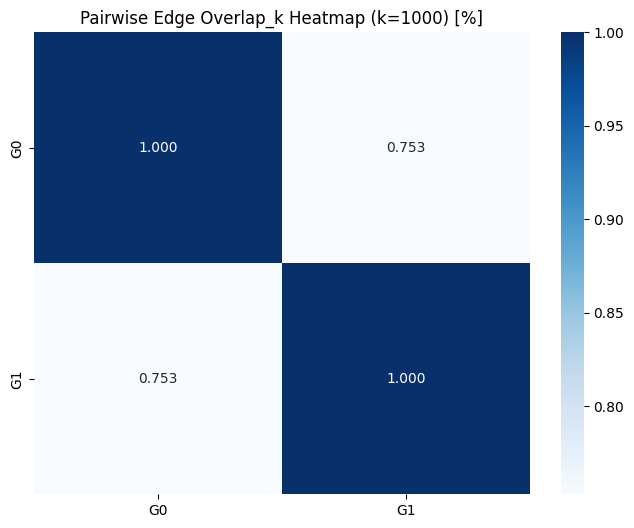

In [29]:
graphs = create_graphs()
edge_matrix = overlap_k(graphs, 2000)
plot_edge_overlap(graphs, edge_matrix)